In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import seaborn as sns
sns.set(style='ticks', context='paper', font_scale=2)
red, blue, green, purple, orange, yellow = sns.color_palette('Set1', 6)
from IPython.display import display_latex


import sys
sys.path.append('../src/')
from simulation import *
from plots import *

In [2]:
from sympy import *
init_printing()

In [3]:
def fig_xlabel(fig, label, x=0.5, y=0):
    return fig.text(x, y, label, horizontalalignment='center', verticalalignment='bottom')

def fig_ylabel(fig, label, x=0, y=0.5):
    return fig.text(x, y, label, rotation='vertical', horizontalalignment='right', verticalalignment='center')

def fig_panel_labels(axes, letters='ABCDEFGHIJKLMNOP', xcoord=-0.17, ycoord=0.92, panel_label_size=plt.rcParams[ 'axes.titlesize']*1.3):
    return [
        ax.annotate(letter, (xcoord, ycoord), xycoords='axes fraction', fontsize=panel_label_size)
        for ax, letter 
        in zip(axes.flat, letters)
    ]

In [255]:
def normed_binomial(N, p):    
    p[(p > 1) & ((p - 1) < 1e-15)] = 1
    p[(p > 0) & (p < 1e-15)] = 0
    return np.random.binomial(N, p) / N

## Recurrence illustration

In [240]:
def recurrence(x, ρ, W, w):
    return x * ( x * (1 - ρ) * (W - w) + ρ * W + (1 - ρ) * w ) / (x * (W - w) + w)

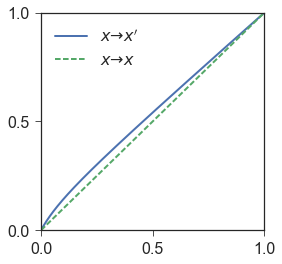

In [242]:
fig, ax = plt.subplots(figsize=(4, 4))
x = np.linspace(0, 1, 10000)
xx = recurrence(x, 0.1, 1.0, 0.1)
assert (0 <= xx).all()
assert (1 >= xx).all()
ax.plot(x, xx, lw=2, label=r"$x \to x'$")
ax.plot(x, x, ls='--', lw=2, label=r"$x \to x$")
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    xticks=np.linspace(0, 1, 3),
    yticks=np.linspace(0, 1, 3),
)
ax.legend()
fig.savefig('../figures/recurrence_example.pdf', dpi=300)

## Environment _A1B1_

In [81]:
x, W, w, ρ = symbols('x W w ρ')
a = (1 - ρ) * (W - w)
b = ρ * W + (1 - ρ) * w
c = W - w
d = w
α = -a 
β = -b + W + w
γ = -c
δ = W

In [82]:
xx = x * (a * x + b)/(c * x + d)
xx

In [83]:
solveset(xx - x, x)

         ⎧ -w  ⎫
{0, 1} \ ⎨─────⎬
         ⎩W - w⎭

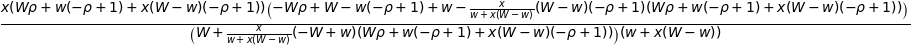

In [84]:
xxx = xx  * (α * xx + β) / (γ * xx + δ)
xxx

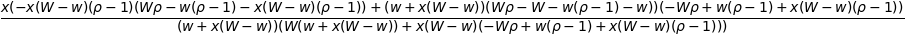

In [85]:
xxx = simplify(xxx)
xxx

In [86]:
sols = solveset(xxx - x, x)
sols

⎧                                _____________________________________________
⎪                               ╱  2  2      2      2          2              
⎨      -W⋅ρ + W + w⋅ρ - 3⋅w - ╲╱  W ⋅ρ  - 2⋅W ⋅ρ + W  - 2⋅W⋅w⋅ρ  + 4⋅W⋅w⋅ρ + 2
⎪0, 1, ───────────────────────────────────────────────────────────────────────
⎩                                          -2⋅W⋅ρ + 4⋅W + 2⋅w⋅ρ - 4⋅w         
                                                                              
                                                                              

___________________________                            _______________________
        2  2      2      2                            ╱  2  2      2      2   
⋅W⋅w + w ⋅ρ  - 2⋅w ⋅ρ + w    -W⋅ρ + W + w⋅ρ - 3⋅w + ╲╱  W ⋅ρ  - 2⋅W ⋅ρ + W  - 
───────────────────────────, ─────────────────────────────────────────────────
                                                                 -2⋅W⋅ρ + 4⋅W 
                                                   

In [87]:
print(sols)

{0, 1, (-W*ρ + W + w*ρ - 3*w - sqrt(W**2*ρ**2 - 2*W**2*ρ + W**2 - 2*W*w*ρ**2 + 4*W*w*ρ + 2*W*w + w**2*ρ**2 - 2*w**2*ρ + w**2))/(-2*W*ρ + 4*W + 2*w*ρ - 4*w), (-W*ρ + W + w*ρ - 3*w + sqrt(W**2*ρ**2 - 2*W**2*ρ + W**2 - 2*W*w*ρ**2 + 4*W*w*ρ + 2*W*w + w**2*ρ**2 - 2*w**2*ρ + w**2))/(-2*W*ρ + 4*W + 2*w*ρ - 4*w)} \ {-w/(W - w), -sqrt((ρ - 1)*(W**2*ρ - W**2 - 2*W*w*ρ - 2*W*w + w**2*ρ - w**2))*(-W + w)/(2*(W**2*ρ - W**2 - 2*W*w*ρ + 2*W*w + w**2*ρ - w**2)) + 1/2, sqrt((ρ - 1)*(W**2*ρ - W**2 - 2*W*w*ρ - 2*W*w + w**2*ρ - w**2))*(-W + w)/(2*(W**2*ρ - W**2 - 2*W*w*ρ + 2*W*w + w**2*ρ - w**2)) + 1/2}


In [108]:
sol0, sol1, sol2, sol3 = 0, 1, (-W*ρ + W + w*ρ - 3*w - sqrt(
    W**2*ρ**2 - 2*W**2*ρ + W**2 - 2*W*w*ρ**2 + 4*W*w*ρ + 2*W*w + w**2*ρ**2 - 2*w**2*ρ + w**2
))/(-2*W*ρ + 4*W + 2*w*ρ - 4*w), (-W*ρ + W + w*ρ - 3*w + sqrt(
    W**2*ρ**2 - 2*W**2*ρ + W**2 - 2*W*w*ρ**2 + 4*W*w*ρ + 2*W*w + w**2*ρ**2 - 2*w**2*ρ + w**2
))/(-2*W*ρ + 4*W + 2*w*ρ - 4*w)

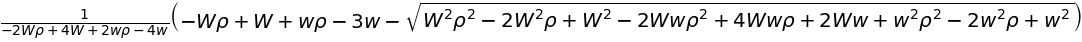

In [109]:
sol2

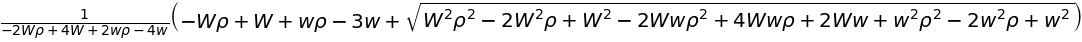

In [110]:
sol3

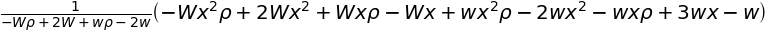

In [111]:
simplify((x-sol2)*(x-sol3))

True


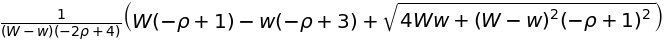

In [112]:
sol3_nicer = (
    (W*(1-ρ) -w*(3-ρ) + sqrt((W-w)**2 * (1-ρ)**2 + 4*W*w))/(2*(2-ρ)*(W-w))
)
print(simplify(sol3 - sol3_nicer) == 0)
sol3_nicer

In [113]:
print_python(sol3_nicer)

W = Symbol('W')
ρ = Symbol('ρ')
w = Symbol('w')
e = (W*(-ρ + 1) - w*(-ρ + 3) + sqrt(4*W*w + (W - w)**2*(-ρ + 1)**2))/((W - w)*(-2*ρ + 4))


In [114]:
latex(sol3_nicer)

'\\frac{1}{\\left(W - w\\right) \\left(- 2 ρ + 4\\right)} \\left(W \\left(- ρ + 1\\right) - w \\left(- ρ + 3\\right) + \\sqrt{4 W w + \\left(W - w\\right)^{2} \\left(- ρ + 1\\right)^{2}}\\right)'

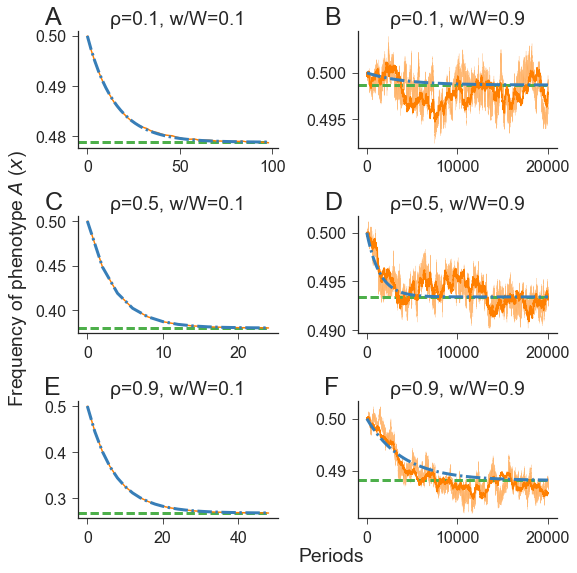

In [298]:
N = 1000000
ns = np.array([[100,20000],[25,20000],[50, 20000]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey=False)

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 2)
        # analytic solution
        subs = [(ρ, ρ_), (W, W_), (w, w_)]
        sol3_ = sol3.subs(subs)
        sol = float(sol3_)
        ax.axhline(y=sol, xmin=0, xmax=0.95, color=green, lw=3, ls='--', label='Equilibrium')        
        # WF
        reps = 100
        x_ = np.empty((n, reps))
        x_[0, :] = 0.5
        y_ = np.empty(n)
        y_[0] = 0.5
        for t in range(1, n):
            wA, wB = (w_, W_) if t % 2 == 0 else (W_, w_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
            x_[t, :] = recurrence(x_[t - 1, :], ρ_, wA, wB)
            x_[t, :] = normed_binomial(N, x_[t, :])
        ci_low = np.percentile(x_, 50.5, axis=1)
        ci_high = np.percentile(x_, 49.5, axis=1) 
        ax.fill_between(
            t_, 
            ci_low[t_], ci_high[t_],
            alpha=0.5, color=orange
        )
        ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Wright-Fisher')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-.', label='Deterministic')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.legend().set_visible(False)

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', x=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ ($x$)', x=0.025)
fig_panel_labels(axes, ycoord=1.05)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A1B1.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight');

## Environment _AABAAB_

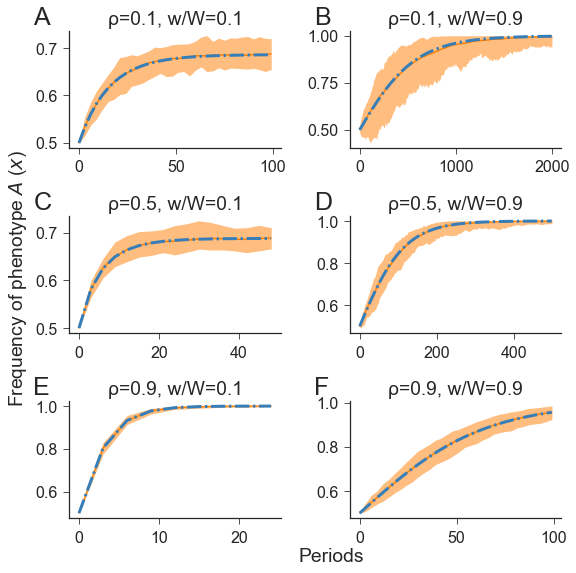

In [304]:
N = 10000
ns = np.array([[100,2000],[50,500],[25, 100]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(8, 8), sharex=False, sharey=False)

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 3)
        # WF
        reps = 100
        x_ = np.empty((n, reps))
        x_[0, :] = 0.5
        y_ = np.empty(n)
        y_[0] = 0.5
        for t in range(1, n):
            wA, wB = (w_, W_) if t % 3 == 0 else (W_, w_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
            x_[t, :] = recurrence(x_[t - 1, :], ρ_, wA, wB)
            x_[t, :] = normed_binomial(N, x_[t, :])
        ci_low = np.percentile(x_, 0.5, axis=1)
        ci_high = np.percentile(x_, 99.5, axis=1) 
        ax.fill_between(
            t_, 
            ci_low[t_], ci_high[t_],
            alpha=0.5, color=orange
        )
        ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Wright-Fisher')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-.', label='Deterministic')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.legend().set_visible(False)

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Periods', x=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ ($x$)', x=0.025)
fig_panel_labels(axes, ycoord=1.05)
fig.tight_layout()
sns.despine()
fig.savefig('../figures/env_A2B1.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight');